> <h1><strong>Fraude</strong></h1>

# **Installs**

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 31.8 MB/s 
     |████████████████████████████████| 81 kB 7.7 MB/s 
     |████████████████████████████████| 209 kB 78.4 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 112 kB 38.3 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 147 kB 47.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=ccae8848b4a51d602b41e8628772326d8bd5f9b95b9e2090b627501a599ec38e
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.0.0
    Uninstalling importlib-metadata-5.0.0:
      Successfully uninstalled importlib-metadata-5.0.0


In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6


! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle
! kaggle datasets download -d mlg-ulb/creditcardfraud
! unzip creditcardfraud.zip

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 26.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72858 sha256=1c03c5188cb780172692acefd8c4eab312a6ac4f772863db2183ca6c20e072a6
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle
 94% 62.0M/66.0M [00:00<00:00, 84.7MB/s]
100% 66.0M/66.0M [00:00<00:00, 77.5MB/s]
Arc

#**Packages**

In [ ]:
############################### DATA ################################
import pandas as pd
import numpy as np
from collections import Counter
############################### PREPROCESSING ################################
from sklearn.metrics import classification_report,confusion_matrix,recall_score,log_loss,precision_score,f1_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import StratifiedShuffleSplit,cross_validate,StratifiedKFold,train_test_split
############################### ANALISYS ################################
from scipy.stats import norm
from statsmodels.formula.api import ols
import statsmodels.api as sm
############################### ML ################################
from xgboost import XGBClassifier
import optuna
from optuna.trial import Trial
import xgboost as xgb
from xgboost import DMatrix
############################### PLOTS ################################
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
############################### WARN ################################
import warnings
warnings.filterwarnings('ignore')

# **Functions**

In [ ]:

def cross_validade(model,x,y,cv,name_model,stratify = None,multi_output=False):

        # CROSS VALIDATION - BEST MODEL
        results_cv = pd.DataFrame()
        stratify_y = stratify if multi_output else y
        
        for idx_cv,(train_index, test_index) in enumerate(cv.split(x,stratify_y),1):
            # ============================ split data ===================================
            X_train, y_train = x.iloc[train_index],y.iloc[train_index]
            X_test, y_test = x.iloc[test_index],y.iloc[test_index]

            # ============================ train model ===================================
            model.fit(X_train, y_train)

            # ============================ predict model ===================================
            y_hat = model.predict(X_test)
            
            # ============================ classifier reports ===================================
            sample_weight = compute_sample_weight(class_weight='balanced', y=y_test)
            cm = confusion_matrix(y_test, y_hat)
            c_report = reports(y_test, y_hat)
            c_report['model'] = name_model
            c_report['CV'] = idx_cv
           
            results_cv = results_cv.append(c_report,ignore_index=True)

        return results_cv

In [ ]:
def reports(y_test, y_hat):
    # ============================ classifier reports ===================================
    sample_weight = compute_sample_weight(class_weight='balanced', y=y_test)
    cm = confusion_matrix(y_test, y_hat)
    c_report = dict()

    c_report['recall'] = recall_score(y_test, y_hat,sample_weight=sample_weight,pos_label=0)
    c_report['precision'] = precision_score(y_test, y_hat,sample_weight=sample_weight,pos_label=1)
    c_report['f1-score'] = f1_score(y_test, y_hat,sample_weight=sample_weight)
    c_report['logloss'] = log_loss(y_test.astype(np.float64), y_hat.astype(np.float64),sample_weight=sample_weight)
    
    c_report['TN'] =cm[0][0]
    c_report['FN'] =cm[0][1]
    c_report['FP'] =cm[1][0]
    c_report['TP'] =cm[1][1]

    return c_report

In [ ]:
def balance(seq):
    n = len(seq)

    classes = [(clas,float(count)) for clas,count in Counter(seq).items()]
    
    k = len(classes)
    
    H = -sum([ (count/n) * np.log((count/n)) for clas,count in classes]) #shannon entropy
    
    return H/np.log(k)

# **Extraction**

In [ ]:
dt = pd.read_csv('/content/creditcard.csv',low_memory=False)
print(f'Linhas:{len(dt)}')
print(f'Colunas:{len(dt.columns)}')

dt.head(3)

Linhas:284807
Colunas:31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


# **Understand data**

In [ ]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
dt.describe().T.style.background_gradient(cmap='coolwarm',axis=0)

,count,mean,std,min,25%,50%,75%,max
Time,284807.000000,94813.859575,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.000000,0.000000,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.000000,0.000000,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.000000,-0.000000,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.000000,0.000000,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.000000,0.000000,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.000000,0.000000,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.000000,-0.000000,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.000000,0.000000,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.000000,-0.000000,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


# **Exploration data**

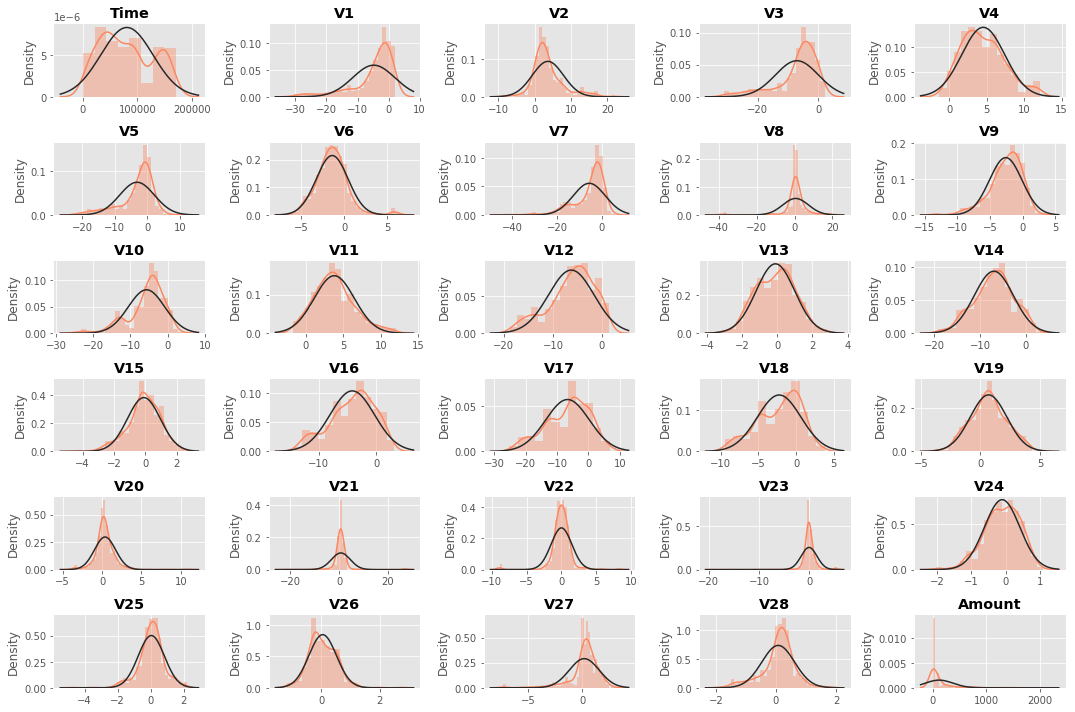

In [ ]:
fig , _ = plt.subplots(6,5, figsize=(15, 10))
for i,c in enumerate(dt.columns[:-1],1):
  ax = plt.subplot(6,5,i)
  fraud_dist = dt[c].loc[dt['Class'] == 1].values
  sns.distplot(fraud_dist, fit=norm, color='#FB8861',ax = ax)
  ax.set_title(c,fontweight='bold')
fig.tight_layout()

In [ ]:
dt['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [ ]:
balance(dt['Class'])

0.018343407709838628

# **Model**

## **Split data**

In [ ]:
y_dt = dt.iloc[:,np.where(dt.columns=='Class')[0]]
x_dt = dt.iloc[:,np.where(dt.columns!='Class')[0]]

## **Feature selection**

In [ ]:


results_tukey = pd.DataFrame()
for i in dt.columns[:-1]:

    moore_lm = ols(f'{i} ~ C(Class)',data=dt).fit()
    anova_results = sm.stats.anova_lm(moore_lm, typ=2) 
    r = {'variable':i,'pvalue':anova_results['PR(>F)']['C(Class)'],'fvalue':anova_results['F']['C(Class)']}
    results_tukey = results_tukey.append(r,ignore_index=True)

    
results_tukey.sort_values('fvalue',ascending=False).style.background_gradient(cmap='coolwarm')

,variable,pvalue,fvalue
17,V17,0.000000,33979.168593
14,V14,0.000000,28695.547788
12,V12,0.000000,20749.822361
10,V10,0.000000,14057.979985
16,V16,0.000000,11443.349428
3,V3,0.000000,11014.508305
7,V7,0.000000,10349.605408
11,V11,0.000000,6999.355047
4,V4,0.000000,5163.832114
18,V18,0.000000,3584.380605


In [ ]:
features_best = list(results_tukey.sort_values('fvalue',ascending=False).variable)

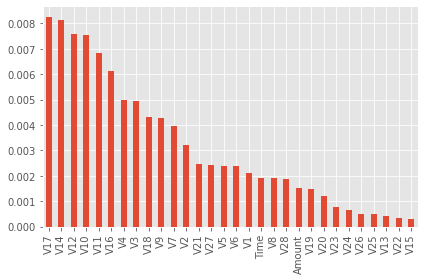

In [ ]:
score = mutual_info_classif(x_dt, y_dt)
mic = pd.Series(score,x_dt.columns)
mic.sort_values(ascending=False).plot(kind='bar')
plt.tight_layout()

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=150, random_state=0)
# clf.fit(x_dt, y_dt)
# rfc_sf = pd.Series(clf.feature_importances_,x_dt.columns)
# rfc_sf.sort_values(ascending=False).plot(kind='bar')

In [ ]:
# rfc_sf.sort_values(ascending=False)

## **Cross validate**

In [ ]:
# BALANCED
scale_pos_weight = np.sqrt(y_dt.value_counts()[0]/y_dt.value_counts()[1])

In [ ]:
# MODELS
xgb_clas = XGBClassifier(objective='binary:logistic',scale_pos_weight=scale_pos_weight)

In [ ]:
# CROSS VALIDATION - BEST MODEL
results_cv = pd.DataFrame()


cv = StratifiedShuffleSplit(n_splits=3, random_state=43,test_size=0.3)

x = x_dt.loc[:,features_best[:5]]

report = cross_validade(model = xgb_clas,
                        x = x,
                        y = y_dt,
                        cv = cv,
                        name_model = 'XGBOOST')
  
results_cv = results_cv.append(report)


>**Results**

In [ ]:
results_cv.groupby(['model']).mean().sort_values('logloss',ascending=False).style.background_gradient(cmap='coolwarm')

,recall,precision,f1-score,logloss,TN,FN,FP,TP,CV
model,,,,,,,,,
XGBOOST,0.999508,0.999417,0.915380,2.692260,85253.000000,42.000000,23.000000,125.000000,2.000000


## **Hyperparameter optimization**

In [ ]:
scale_pos_weight_min = np.sqrt(y_dt.value_counts()[0]/y_dt.value_counts()[1])

In [ ]:
%%time
# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values of the hyperparameters using a trial object.
    
    params = dict()
    params['objective'] = trial.suggest_categorical('objective',['binary:logistic'])
    params['tree_method'] = trial.suggest_categorical('tree_method',['hist'])
    params['single_precision_histogram'] = trial.suggest_categorical('single_precision_histogram',[False])
    params['booster'] = trial.suggest_categorical('booster', ['gbtree'])
    params['eval_metric'] = trial.suggest_categorical('eval_metric',['logloss'])
    params['learning_rate'] = trial.suggest_float('learning_rate',0.0001,1.0,step=0.0001)
    params['scale_pos_weight'] = trial.suggest_categorical('scale_pos_weight',[scale_pos_weight_min])
    params['max_depth'] = trial.suggest_int('max_depth',6,16)
    params['min_child_weight'] = trial.suggest_int('min_child_weight',1,10)
    params['gamma'] = trial.suggest_float('gamma', 0.0,1.0,step=0.01)
    params['colsample_bylevel'] = trial.suggest_float('colsample_bylevel', 0.5,1.0,step=0.1)

    dtrain = DMatrix(x_dt.loc[:,features_best[:5]],y_dt)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-logloss")

    results = xgb.cv(params,
                      dtrain = dtrain,
                      # num_boost_round=110,
                      nfold=3, 
                      stratified=True, 
                      # early_stopping_rounds=1,
                      seed=43,
                      verbose_eval=False,
                      metrics = list(['logloss']),
                      shuffle=True,
                      maximize=True,
                      callbacks=[pruning_callback]
                    )
    return results['test-logloss-mean'].mean()

sampler = optuna.samplers.TPESampler(multivariate=True)
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(sampler=sampler,directions=['maximize'])

study.optimize(objective, n_trials=100,show_progress_bar=True)

[I 2022-10-11 13:51:51,717] A new study created in memory with name: no-name-4e335cbd-b11c-40c9-980b-91280f48d3d6


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-10-11 13:51:53,827] Trial 0 finished with value: 0.05785523333333333 and parameters: {'objective': 'binary:logistic', 'tree_method': 'hist', 'single_precision_histogram': False, 'booster': 'gbtree', 'eval_metric': 'logloss', 'learning_rate': 0.5981, 'scale_pos_weight': 24.039051900192792, 'max_depth': 15, 'min_child_weight': 4, 'gamma': 0.67, 'colsample_bylevel': 0.7}. Best is trial 0 with value: 0.05785523333333333.
[I 2022-10-11 13:51:55,966] Trial 1 finished with value: 0.1938369 and parameters: {'objective': 'binary:logistic', 'tree_method': 'hist', 'single_precision_histogram': False, 'booster': 'gbtree', 'eval_metric': 'logloss', 'learning_rate': 0.2297, 'scale_pos_weight': 24.039051900192792, 'max_depth': 13, 'min_child_weight': 10, 'gamma': 0.03, 'colsample_bylevel': 0.7}. Best is trial 1 with value: 0.1938369.
[I 2022-10-11 13:51:58,074] Trial 2 finished with value: 0.29294386666666666 and parameters: {'objective': 'binary:logistic', 'tree_method': 'hist', 'single_prec

In [ ]:
fig = optuna.visualization.plot_edf([study])
fig.show()

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

In [ ]:
best = study.trials_dataframe().sort_values(['value'],ascending=False)
best.head()

,number,value,datetime_start,datetime_complete,duration,params_booster,params_colsample_bylevel,params_eval_metric,params_gamma,params_learning_rate,params_max_depth,params_min_child_weight,params_objective,params_scale_pos_weight,params_single_precision_histogram,params_tree_method,state
24,24,0.692055,2022-10-11 13:52:32.900897,2022-10-11 13:52:34.891663,0 days 00:00:01.990766,gbtree,0.7,logloss,0.19,0.0001,16,3,binary:logistic,24.039052,False,hist,COMPLETE
60,60,0.678613,2022-10-11 13:53:24.381406,2022-10-11 13:53:26.305846,0 days 00:00:01.924440,gbtree,0.8,logloss,0.52,0.0027,15,5,binary:logistic,24.039052,False,hist,COMPLETE
81,81,0.677030,2022-10-11 13:53:50.124413,2022-10-11 13:53:52.109781,0 days 00:00:01.985368,gbtree,0.8,logloss,0.55,0.0030,13,5,binary:logistic,24.039052,False,hist,COMPLETE
88,88,0.674664,2022-10-11 13:54:00.047789,2022-10-11 13:54:01.924083,0 days 00:00:01.876294,gbtree,0.7,logloss,0.40,0.0035,16,8,binary:logistic,24.039052,False,hist,COMPLETE
43,43,0.670397,2022-10-11 13:53:01.647633,2022-10-11 13:53:03.570147,0 days 00:00:01.922514,gbtree,0.8,logloss,0.51,0.0042,13,2,binary:logistic,24.039052,False,hist,COMPLETE


In [ ]:
params = best.iloc[0,6:-1].to_dict()
params = {k.replace('params_',''):v for k,v in params.items()}
params

{'colsample_bylevel': 0.7,
 'eval_metric': 'logloss',
 'gamma': 0.19,
 'learning_rate': 0.0001,
 'max_depth': 16,
 'min_child_weight': 3,
 'objective': 'binary:logistic',
 'scale_pos_weight': 24.039051900192792,
 'single_precision_histogram': False,
 'tree_method': 'hist'}

In [ ]:
params = {'colsample_bylevel': 0.6,
 'eval_metric': 'logloss',
 'gamma': 0.22,
 'learning_rate': 0.0004,
 'max_depth': 10,
 'min_child_weight': 6,
 'objective': 'binary:logistic',
 'scale_pos_weight': 24.039051900192792,
 'single_precision_histogram': False,
 'tree_method': 'hist'}

In [ ]:
# params = {'objective':'binary:logistic','scale_pos_weight':scale_pos_weight}

In [ ]:
%%time
x_train,x_test,y_train,y_test = train_test_split(x_dt.loc[:,features_best[:5]],y_dt,test_size=0.3,stratify=y_dt,random_state=43)

dtrain = DMatrix(x_train,y_train)
dtest = DMatrix(x_test)

# 2. Suggest values of the hyperparameters using a trial object.
model = xgb.train(params, dtrain)
# print('Train score:',xgb.)
y_scores = model.predict(dtest,ntree_limit = model.best_ntree_limit)
yhat = np.rint(y_scores)
print(pd.DataFrame(reports(y_test,yhat),index=['Results']).T)

                Results
recall         0.999472
precision      0.999376
f1-score       0.915489
logloss        2.692867
TN         85250.000000
FN            45.000000
FP            23.000000
TP           125.000000
CPU times: user 1.87 s, sys: 25.8 ms, total: 1.9 s
Wall time: 2.4 s


In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")


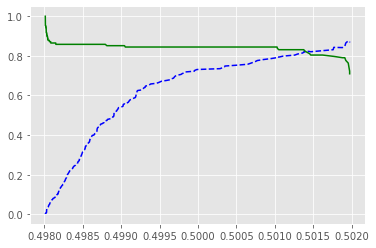

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test,y_scores)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
#PLOT ROC
def plot_roc_curve(fpr, tpr, label=None):
 plt.plot(fpr, tpr, linewidth=2, label=label)
 plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
# Add axis labels and grid

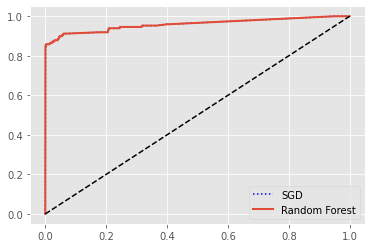

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve
fpr, tpr, thresholds = roc_curve(y_test,y_scores, pos_label=1)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr, tpr, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [ ]:
import scipy
from sklearn.metrics import f1_score

def thr_to_accuracy(thr, Y_test, predictions):
   return -f1_score(Y_test, np.array(predictions>thr, dtype=np.int))

best_thr = scipy.optimize.fmin(thr_to_accuracy, args=(y_test,y_scores), x0=0.5)

y_labels_threshold = (y_scores >= best_thr)
print(best_thr)
reports(y_test, y_labels_threshold)

Optimization terminated successfully.
         Current function value: -0.825503
         Iterations: 15
         Function evaluations: 35
[0.50136719]


{'recall': 0.9996834515505009,
 'precision': 0.99961925745485,
 'f1-score': 0.9075921773406478,
 'logloss': 2.9225931093186546,
 'TN': 85268,
 'FN': 27,
 'FP': 25,
 'TP': 123}